In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTENC
from sklearn.utils import class_weight
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
import pickle

In [2]:
# Load data
df = pd.read_csv("dataset.csv")
pd.options.mode.chained_assignment = None
df.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,No Failure


In [3]:
# Check for duplicates
df.duplicated().sum()

0

In [4]:
# Check for missing values
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [5]:
# Verify data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [6]:
# Numeric features analysis
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [7]:
# Verify “Target” column distribution
df.Target.value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

In [8]:
# Verify “Failure Type” distribution
df["Failure Type"].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

In [9]:
# Rename columns for clarity
rename_columns = {
    "UDI": "ID",
    "Air temperature [K]": "Air_temperature",
    "Process temperature [K]": "Process_temperature",
    "Rotational speed [rpm]": "Rotational_speed",
    "Torque [Nm]": "Torque",
    "Tool wear [min]": "Tool_wear",
    "Product ID": "Product_ID",
    "Failure Type": "Failure_type"    
}
df.rename(rename_columns, axis = 1, inplace = True)

In [10]:
# Identify redundant rows
count_failures = (df["Target"] == 1).sum()
print("Number of total failures:", count_failures)

# Sum of occurrences of "Failure_type" other than "No Failure"
sum_failures = df.loc[(df["Failure_type"] != "No Failure") & (df["Target"] == 1), "Failure_type"].count()
print("Sum of actual failures:", sum_failures)

Number of total failures: 339
Sum of actual failures: 330


In [11]:
# Remove redundant rows
rows_to_remove = df[(df["Target"] == 1) & (df["Failure_type"] == "No Failure")]
df.drop(rows_to_remove.index, inplace = True)

In [12]:
# Remove unnecessary columns
drop_columns = ["ID", "Product_ID", "Target"]
df.drop(drop_columns, axis = 1, inplace = True)

In [13]:
# Remove “Random Failures”
df = df.loc[df["Failure_type"] != "Random Failures"]

In [14]:
# Rename classes of “Type” column
rename_type = {
    "L": "Low",
    "M": "Medium",
    "H": "High"
}
df["Type"].replace(rename_type, inplace = True)

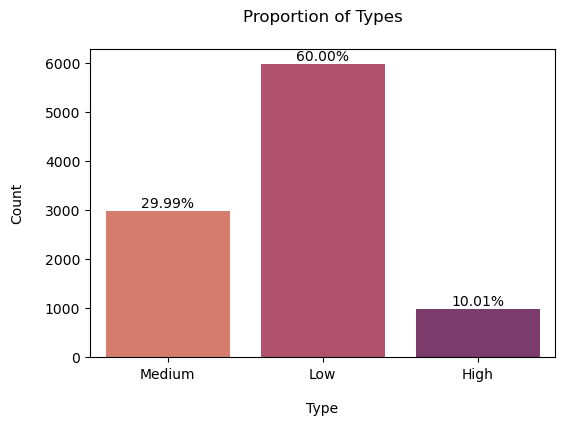

In [15]:
# Plot “Type” distribution

# Count types
tipo_contagem = df["Type"].value_counts()

# Show graphic
plt.figure(figsize = (6,4))
ax = sns.countplot(data = df, x = "Type", palette = "flare")
plt.title("Proportion of Types", pad = 20)
plt.xlabel("Type", labelpad = 15)
plt.ylabel("Count", labelpad = 15)

# Add as percentages as labels
total = len(df["Type"])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f"{percentage:.2f}%", (p.get_x() + p.get_width() / 2, height), ha = "center", va = "bottom")
plt.show()

---
**Observations:** We can see clearly here that the "Low" type accounts for the majority of all types of machines.

---

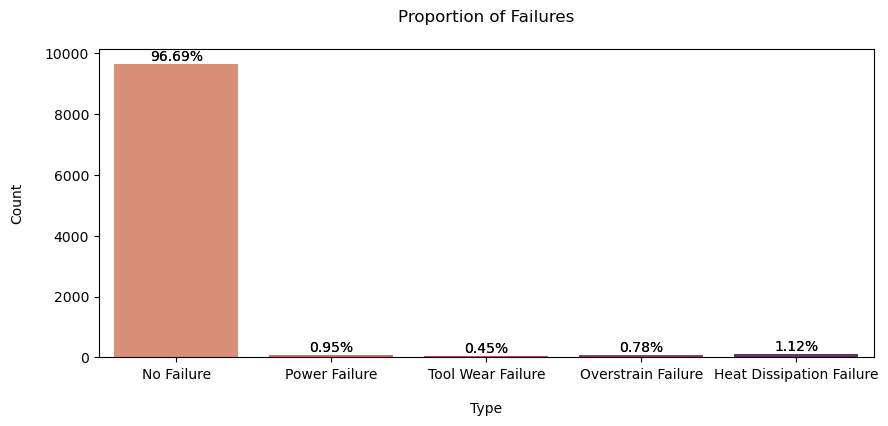

In [16]:
# Plot “Failure_type” distribution
tipo_contagem = df["Failure_type"].value_counts()

# Plot bar graphic
plt.figure(figsize = (10, 4))
ax = sns.countplot(data = df, x = "Failure_type")
plt.title("Proportion of Failures", pad = 20)
plt.xlabel("Type", labelpad = 15)
plt.ylabel("Count", labelpad = 15)
ax = sns.countplot(data = df, x = "Failure_type", palette = "flare")

# Add as percentages as labels
total = len(df["Failure_type"])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f"{percentage:.2f}%", (p.get_x() + p.get_width() / 2, height),
                ha = "center", va = "bottom")
plt.show()

---
**Observations:** The graph above reveals that the classes are unbalanced. We'll also need to pay attention to multi-class problems.

---

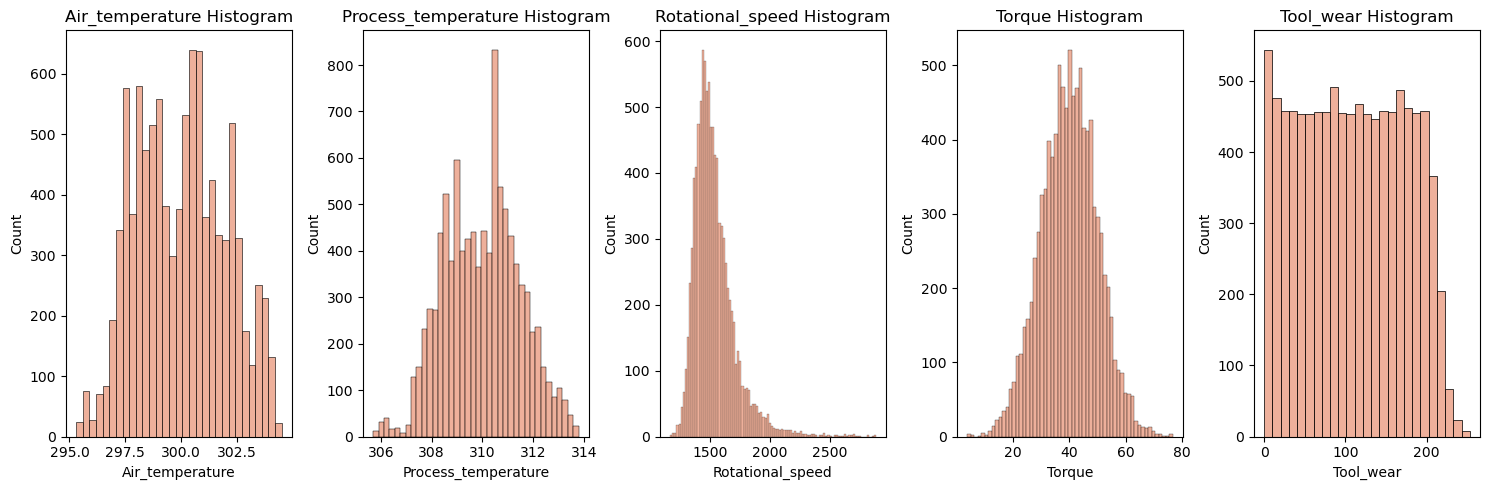

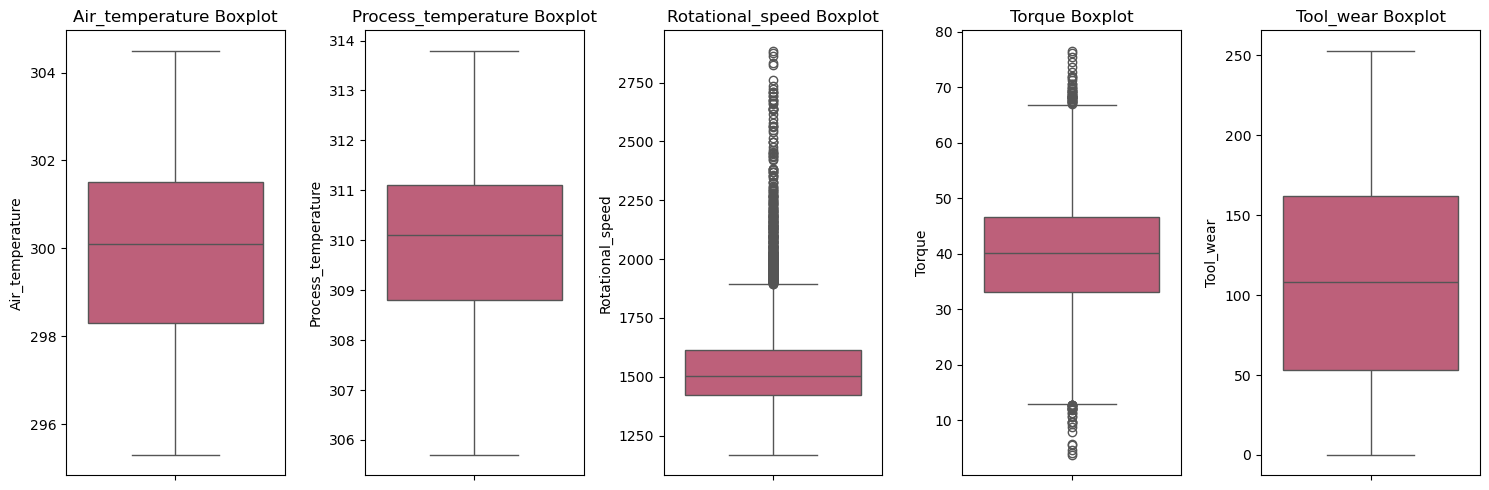

In [17]:
# Plot histogram and boxplot with numeric features
numeric_features = ["Air_temperature", "Process_temperature", "Rotational_speed", "Torque", "Tool_wear"]
categorical_features = ["Type"]

# Create figure and axes
fig, axes = plt.subplots(nrows = 1, ncols = len(numeric_features), figsize = (15, 5))

# Plot histograms 
for i, feature in enumerate(numeric_features):
    sns.histplot(data = df, x = feature, ax = axes[i], color = "darksalmon")
    axes[i].set_title(f"{feature} Histogram")

# Adjust subplot 
plt.tight_layout()

# Show histogram 
plt.show()

# Create figure and axes
fig, axes = plt.subplots(nrows = 1, ncols = len(numeric_features), figsize = (15, 5))

# Plot boxplot side by side
for i, feature in enumerate(numeric_features):
    sns.boxplot(data = df, y = feature, ax = axes[i], color = "#cc5074")
    axes[i].set_title(f"{feature} Boxplot")

# Adjust subplot
plt.tight_layout()

# Show boxplots
plt.show()

---
**Observations:** We can see from the histograms that the 'rotation_speed' variable has an asymmetrical distribution with positive skewness: the right tail is longer and the mass of the distribution is concentrated on the left of the figure. This variable, as well as the 'torque' feature, have outliers too as revealed by the boxplots. This is something we need to be careful with when building our model and interpreting the results.

---

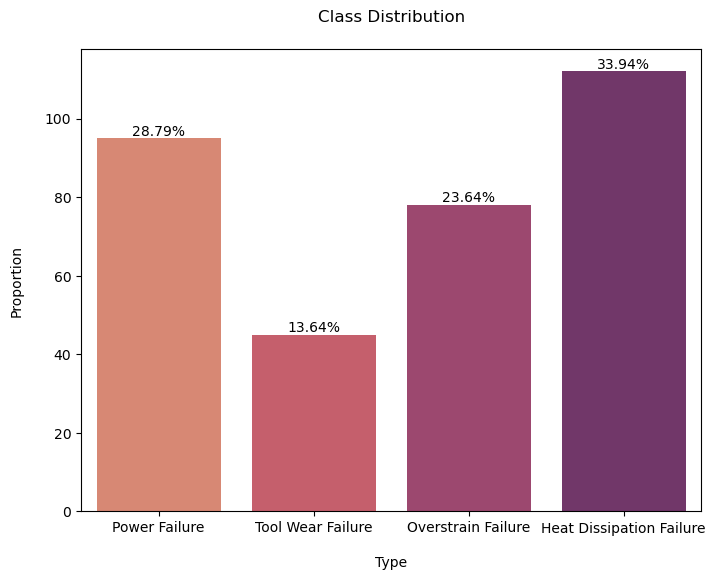

In [18]:
# Plot distribution of failures
df_failure_type = df.loc[df["Failure_type"] != "No Failure"]
proportions = df_failure_type["Failure_type"].value_counts(normalize = True)

# Show graphic
plt.figure(figsize = (8, 6))
ax = sns.countplot(data = df_failure_type, x = "Failure_type", palette = "flare")
plt.title("Class Distribution", pad = 20)
plt.xlabel("Type", labelpad = 15)
plt.ylabel("Proportion", labelpad = 15)

# Add as percentages as labels
total = len(df_failure_type["Failure_type"])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f"{percentage:.2f}%", (p.get_x() + p.get_width() / 2, height),
                ha = "center", va = "bottom")
plt.show()

---
**Observations:** Apart from the 'Tool Wear Failure', all other types of failure are pretty well balanced.

---

<Axes: >

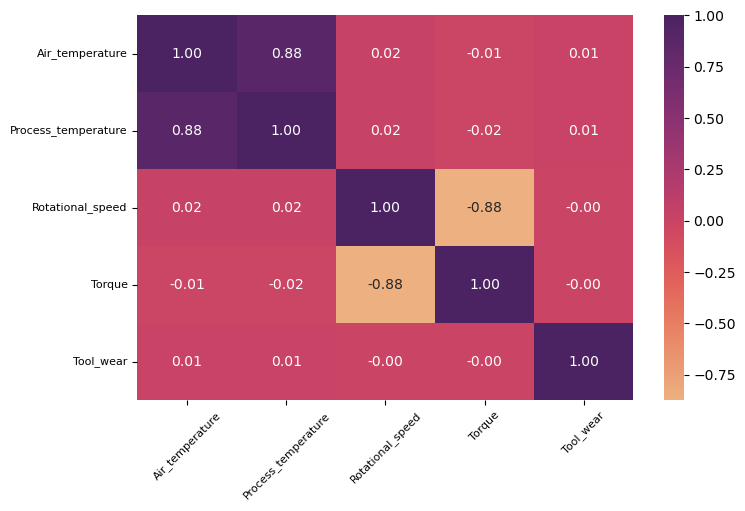

In [19]:
# Plot correlation of numeric features
corr = df[numeric_features].corr()
plt.figure(figsize = (8, 5))
plt.xticks(fontsize = 8, rotation = 45)
plt.yticks(fontsize = 8)
sns.heatmap(corr, annot = True, cmap = "flare", fmt = ".2f")

---
**Observations:** We can see from the heatmpat below that the 'Air_temperature' and 'Process_temperature' are highly correlated, suggesting that when air temeperature increases, the process temperature increases too. 

On the other hand, the 'Rotational_speed' and 'Torque' do not appear to be correlated at all.

---

In [20]:
# Scale numeric features and apply OneHotEncoder to categorical features

# Define pipelines for numeric and categorical transformations
num_pipeline = Pipeline([("num_features", StandardScaler())])
cat_pipeline = Pipeline([("cat_features", OneHotEncoder())])

# Create ColumnTransformer
preprocessor = ColumnTransformer(transformers=[("num_trans", num_pipeline, numeric_features),
                                               ("cat_trans", cat_pipeline, categorical_features)])

# Fit and transform data
df_transformed = preprocessor.fit_transform(df)

# Convert transformed data back to a dataframe 
encoded_feature_names = preprocessor.named_transformers_["cat_trans"].get_feature_names_out(categorical_features)
new_column_names = list(numeric_features) + list(encoded_feature_names)

df_transformed = pd.DataFrame(df_transformed, columns=new_column_names)
df_transformed.head(10)

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_High,Type_Low,Type_Medium
0,-0.951417,-0.946356,0.067484,0.283054,-1.695647,0.0,0.0,1.0
1,-0.901428,-0.878954,-0.729604,0.634238,-1.648511,0.0,1.0,0.0
2,-0.951417,-1.013759,-0.227940,0.945286,-1.617087,0.0,1.0,0.0
3,-0.901428,-0.946356,-0.590253,-0.048061,-1.585664,0.0,1.0,0.0
4,-0.901428,-0.878954,-0.729604,0.002108,-1.554240,0.0,1.0,0.0
5,-0.951417,-0.946356,-0.634845,0.192750,-1.522816,0.0,0.0,1.0
6,-0.951417,-0.946356,0.106502,0.242919,-1.475680,0.0,1.0,0.0
7,-0.951417,-0.946356,-0.066293,0.022175,-1.444256,0.0,1.0,0.0
8,-0.851439,-0.878954,0.714072,-1.141746,-1.412833,0.0,0.0,1.0
9,-0.751461,-0.676745,1.126551,-1.201949,-1.365697,0.0,0.0,1.0


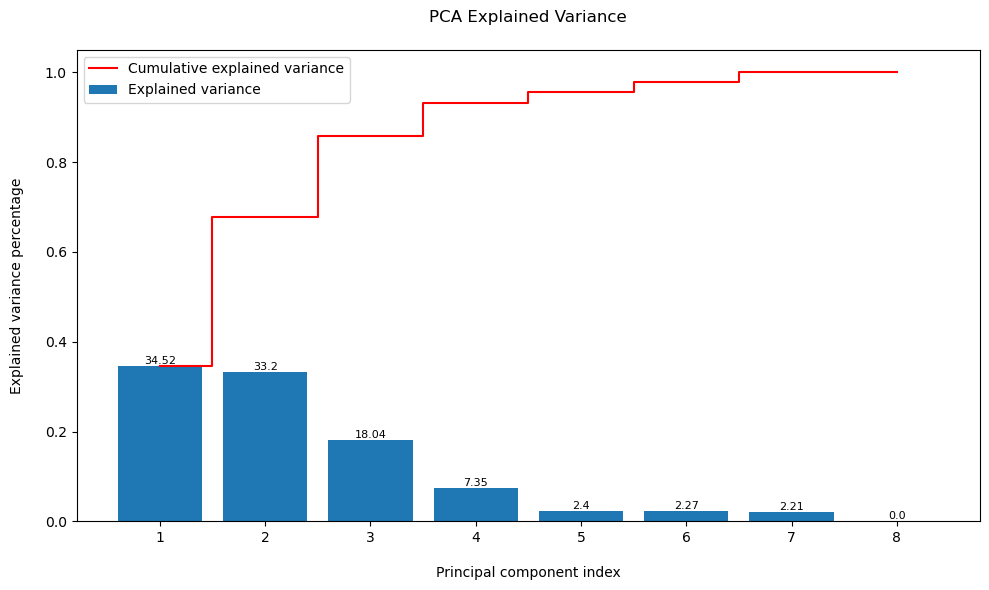

In [21]:
# PCA Analysis
pca = PCA()
pca.fit(df_transformed)  

# PCA variance explained
exp_var = pca.explained_variance_ratio_
cum_exp_var = exp_var.cumsum()

# Find number of components
n_pca_components = len(exp_var)

# Plot data
plt.figure(figsize = (10,6))
bars = plt.bar(range(1, n_pca_components + 1), exp_var, align = "center", label = "Explained variance")
plt.step(range(1, n_pca_components + 1), cum_exp_var, where = "mid", label = "Cumulative explained variance", color = "red")

# Add labels 
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval * 100, 2), va = "bottom", ha = "center", fontsize = 8)

plt.ylabel("Explained variance percentage", labelpad = 15)
plt.xlabel("Principal component index", labelpad = 15)
plt.xticks(ticks = list(range(1, n_pca_components + 1)))
plt.title("PCA Explained Variance", pad = 20)
plt.legend(loc = "best")
plt.tight_layout()
plt.show()

---
**Observations:** We can see from the graph above that we need 4 components to retain 90% of the variance. 

---

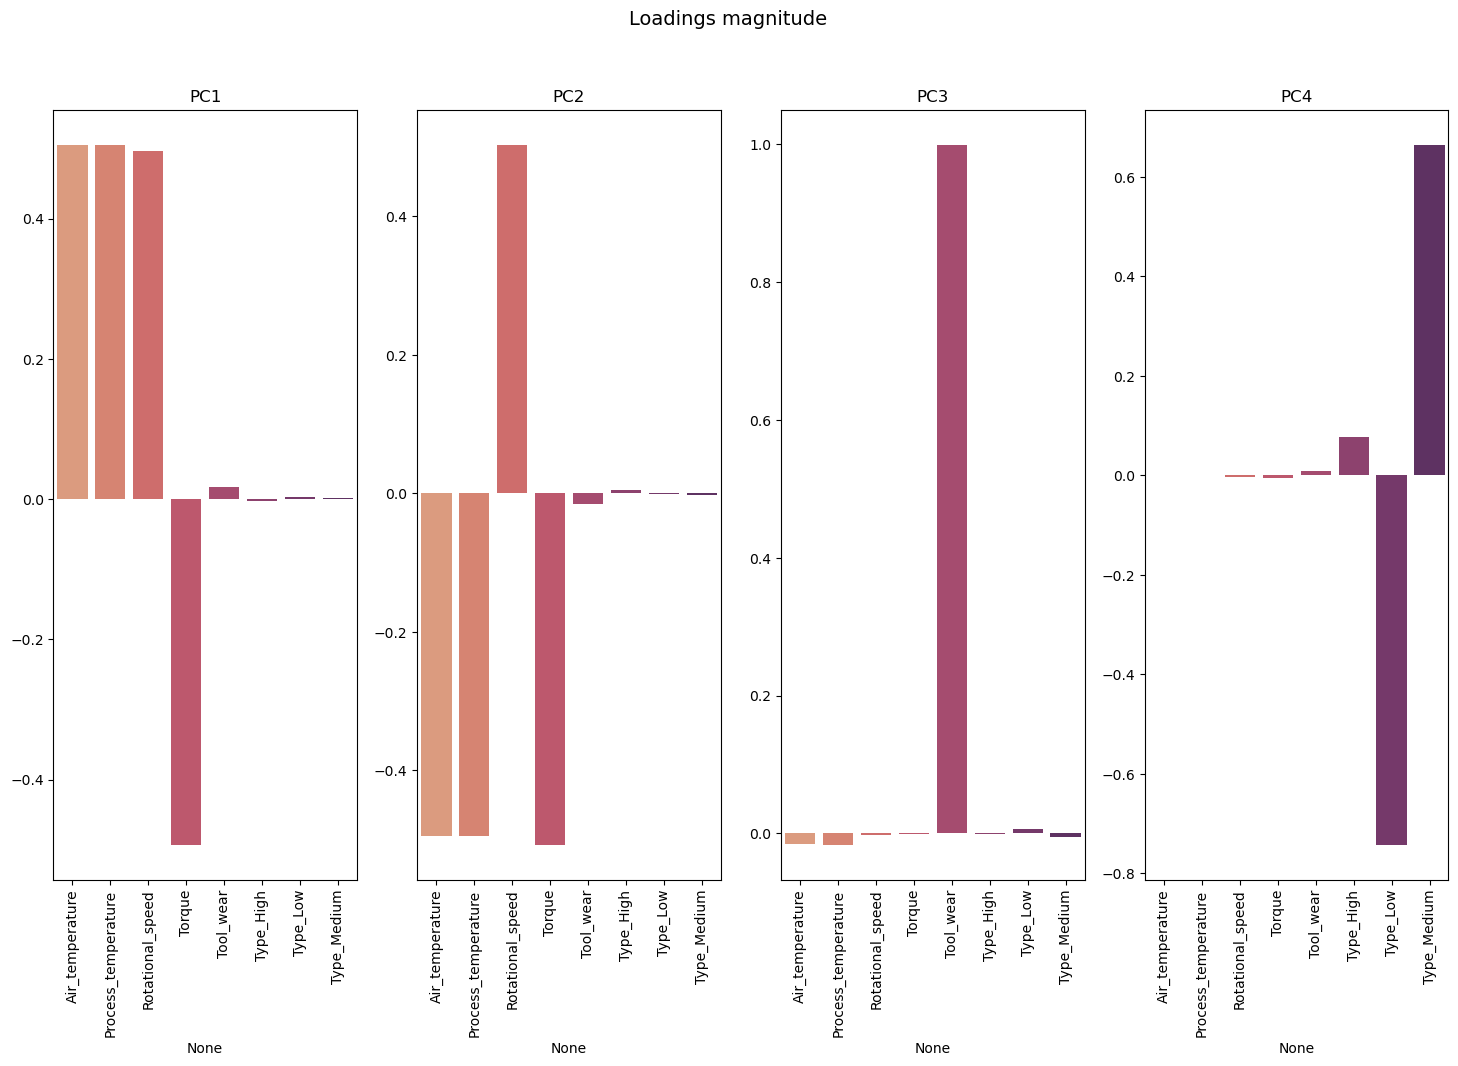

In [22]:
# Plot PCA with 4 components 
pca4 = PCA(n_components = 4)
X_pca4 = pd.DataFrame(data = pca4.fit_transform(df_transformed), columns = ["PC1", "PC2", "PC3", "PC4"])

fig, axs = plt.subplots(ncols = 4, figsize = (18, 10))
fig.suptitle("Loadings magnitude", fontsize = 14)

all_features = numeric_features + list(encoded_feature_names)  
pca_loadings = pd.DataFrame(data = pca4.components_, columns = all_features)

for j in range(4):
    ax = axs[j]
    sns.barplot(ax = ax, x = pca_loadings.columns, y = pca_loadings.values[j], palette = "flare")
    ax.tick_params(axis = "x", rotation = 90)
    ax.title.set_text("PC" + str(j + 1))
    
plt.show()

In [23]:
# Modeling

# Create a function to get metrics
def get_metrics(y_true, y_pred):
    f1_scores_per_class = f1_score(y_true, y_pred, average = None)
    
    dict_metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Balanced Accuracy": balanced_accuracy_score(y_true, y_pred),
        "Macro Recall": recall_score(y_true, y_pred, average = "macro"),
        "Macro Precision": precision_score(y_true, y_pred, average = "macro"),
        "Macro F1": f1_score(y_true, y_pred, average = "macro"),
        "F1 Scores per Class": f1_scores_per_class
    }
    return dict_metrics

In [24]:
# Split data into train and test sets
df_model = df.copy()
X = df_model[numeric_features + categorical_features]
y = df_model["Failure_type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2, stratify = y)

In [25]:
# Create model with PCA and class_weight

# Creating pipeline with PCA analysis and balanced class
pip_model_pca = Pipeline(steps = [("preprocessor", preprocessor), ("pca", PCA(n_components = 4)),
                                  ("model", RandomForestClassifier(random_state = 2023))])

# Fit pipeline with PCA
weights = class_weight.compute_sample_weight(class_weight = "balanced", y = y_train)
pip_model_pca.fit(X_train, y_train, model__sample_weight = weights)

# Generate predictions using the fitted pipeline
y_pred = pip_model_pca.predict(X_test)

# Evaluate metrics
metrics = get_metrics(y_test, y_pred)

# View results
metrics

{'Accuracy': 0.9699248120300752,
 'Balanced Accuracy': 0.2730263157894737,
 'Macro Recall': 0.2730263157894737,
 'Macro Precision': 0.5607310529845742,
 'Macro F1': 0.3078965813354376,
 'F1 Scores per Class': array([0.        , 0.98493745, 0.45454545, 0.1       , 0.        ])}

---
**Observations:** With this model, the accuracy is high but the macro F1 score is low, suggesting that this is probably not the best fitted model for our data.

---

In [26]:
# Create model without PCA and with class_weight

# Create pipeline without PCA analysis
pip_model_no_pca = Pipeline(steps = [("preprocessor", preprocessor), ("model", GradientBoostingClassifier(random_state = 2023))])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight = "balanced", y = y_train)
pip_model_no_pca.fit(X_train, y_train, model__sample_weight = weights)

# Generate predictions
y_pred = pip_model_no_pca.predict(X_test)

# Evaluate metrics
metrics = get_metrics(y_test, y_pred)

# View results
metrics

{'Accuracy': 0.9543859649122807,
 'Balanced Accuracy': 0.8088413913217465,
 'Macro Recall': 0.8088413913217465,
 'Macro Precision': 0.5805520745597669,
 'Macro F1': 0.6480662154359346,
 'F1 Scores per Class': array([0.78571429, 0.9762533 , 0.53658537, 0.7804878 , 0.16129032])}

---
**Observations:** Without the PCA, we get better results overall. The performance of our model improved significantly, which suggests that we lost valuable information using only 4 components.

---

In [27]:
# Create model without PCA but with SMOTE-NC

# Get categorical feature indices for SMOTENC
categorical_features_indices = [i for i, feature in enumerate(numeric_features + categorical_features) 
                                if feature in categorical_features]

# Create new pipeline with SMOTENC using ImbPipeline
pip_model_smotenc = ImbPipeline(steps = [("preprocessor", preprocessor),
                                         ("smotenc", SMOTENC(categorical_features = categorical_features_indices, random_state = 42)),
                                         ("model", GradientBoostingClassifier(random_state=2023))])

# Fit pipeline
pip_model_smotenc.fit(X_train, y_train)

# Generate predictions
y_pred = pip_model_smotenc.predict(X_test)

# Evaluate metrics
metrics = get_metrics(y_test, y_pred)

# View results
metrics

{'Accuracy': 0.9458646616541353,
 'Balanced Accuracy': 0.8442677780506216,
 'Macro Recall': 0.8442677780506216,
 'Macro Precision': 0.5654740940495777,
 'Macro F1': 0.6463632745028389,
 'F1 Scores per Class': array([0.8       , 0.97159543, 0.63636364, 0.69565217, 0.12820513])}

---
**Observations:** Using SMOTE-NC to deal with the unbalanced classes instead of class weights does not prove to a better approach here. Let's continue with GridSearchCV to search through the best parameter values.

---

In [28]:
# Use GridSearchCV to find a better model

# Create pipeline without PCA analysis
pip_model_no_pca = Pipeline(steps = [("preprocessor", preprocessor), ("model", GradientBoostingClassifier(random_state = 2023))])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight = "balanced", y = y_train)
pip_model_no_pca.fit(X_train, y_train, model__sample_weight = weights)

# Update parameters for GridSearchCV
params = {"model": [LogisticRegressionCV(max_iter = 500, random_state = 2023),
                    RandomForestClassifier(random_state = 2023),
                    GradientBoostingClassifier(random_state = 2023),
                    DummyClassifier()]}

# Run GridSearchCV
grid = GridSearchCV(pip_model_no_pca, params, cv = 3, scoring = "f1_macro", n_jobs = -1, verbose = 1)
grid.fit(X_train, y_train)

# Collect and print results
results = pd.DataFrame(grid.cv_results_)
best_model_index = results["mean_test_score"].idxmax()
best_model_params = results.loc[best_model_index, "params"]

print("The best model is:", best_model_params["model"])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The best model is: GradientBoostingClassifier(random_state=2023)


---
**Observations:** GridSearchCV reveals that the best classifier for our model is GradientBoostingClassifier. We can now tune the hyperparameters of our model.

---

In [29]:
# Tune model
fine_tune_params = {
    "model__n_estimators": [50, 100, 200, 300, 400, 500],
    "model__max_depth": [None, 5, 10, 15, 20]
}

# Run a new GridSearchCV for fine-tuning
fine_tune_grid = GridSearchCV(pip_model_no_pca, fine_tune_params, cv = 3, scoring = "f1_macro", n_jobs = -1, verbose = 1)
fine_tune_grid.fit(X_train, y_train)

# Collect results
fine_tuned_results = pd.DataFrame(fine_tune_grid.cv_results_)
fine_tuned_best_index = fine_tuned_results["mean_test_score"].idxmax()
fine_tuned_best_params = fine_tuned_results.loc[fine_tuned_best_index, "params"]

# Print best model parameters
print("The best fine-tuned model parameters are:")
print(fine_tuned_best_params)

# Find best estimator paramaters
tuned_model = fine_tune_grid.best_estimator_
y_pred = tuned_model.predict(X_test)

# View new perfomance (F1-score)
get_metrics(y_test, y_pred)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
The best fine-tuned model parameters are:
{'model__max_depth': 5, 'model__n_estimators': 300}


{'Accuracy': 0.9819548872180451,
 'Balanced Accuracy': 0.6507613893704998,
 'Macro Recall': 0.6507613893704998,
 'Macro Precision': 0.6442967439259306,
 'Macro F1': 0.6462963773144292,
 'F1 Scores per Class': array([0.85106383, 0.99094437, 0.6       , 0.78947368, 0.        ])}

---
**Observations:** This model has a better macro precision and accuracy, but at a cost: The balanced accuracy and macro recall have both dropped down by 19%. Considering that our dataset was imbalanced, it is not so surprising. To have a better idea of how well our model performed, we would have to compute the metrics independently for each class and take the average of the sum.

---